In [32]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load the data
df_portfolio_train = pd.read_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021 = pd.read_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022 = pd.read_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023 = pd.read_parquet('datasets/df_portfolio_2023.parquet')
df_portfolio_test = pd.read_parquet('datasets/df_portfolio_test.parquet')

TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

df_portfolio_vali = df_portfolio_train[df_portfolio_train["date"] >= "2022-01-01"]
df_portfolio_train = df_portfolio_train[df_portfolio_train["date"] < "2022-01-01"]

10


In [3]:
# # testing utils.py
# """From FinRL https://github.com/AI4Finance-LLC/FinRL/tree/master/finrl/env"""
# from __future__ import annotations

# import math

# import gym
# import matplotlib
# import numpy as np
# import pandas as pd
# from gym import spaces
# from gym.utils import seeding

# matplotlib.use("Agg")
# import matplotlib.pyplot as plt
# from stable_baselines3.common.vec_env import DummyVecEnv
# from pathlib import Path

# try:
#     import quantstats as qs
# except ModuleNotFoundError:
#     raise ModuleNotFoundError(
#         """QuantStats module not found, environment can't plot results and calculate indicators.
#         This module is not installed with FinRL. Install by running one of the options:
#         pip install quantstats --upgrade --no-cache-dir
#         conda install -c ranaroussi quantstats
#         """
#     )

# def custom_reward_function(asset_memory, risk_penalty=0.1, max_drawdown_penalty=0.1):
#     # Portfolio return calculation
#     rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
#     portfolio_return = rate_of_return - 1
#     max_drawdown = qs.stats.max_drawdown(pd.Series(asset_memory["final"]))  # Should max drawdown be calculated over a moving window?
#     drawdown_penalty = max_drawdown * max_drawdown_penalty

#     # Risk-based penalty: could be volatility or other risk metrics
#     volatility = np.std(pd.Series(asset_memory["final"]))
#     risk_penalty = volatility * risk_penalty

#     # Reward function with penalties
#     portfolio_reward = np.log(1 + rate_of_return) + drawdown_penalty - risk_penalty
#     return portfolio_return, portfolio_reward

# def sharpe_ratio_reward_function(asset_memory):  # Does this work
#     rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
#     portfolio_return = rate_of_return - 1
#     sharpe = qs.stats.sharpe(portfolio_return)
#     return portfolio_return, sharpe

# class PortfolioOptimizationEnv(gym.Env):
#     """A portfolio allocation environment for OpenAI gym.

#     This environment simulates the interactions between an agent and the financial market
#     based on data provided by a dataframe. The dataframe contains the time series of
#     features defined by the user (such as closing, high and low prices) and must have
#     a time and a tic column with a list of datetimes and ticker symbols respectively.
#     An example of dataframe is shown below::

#             date        high            low             close           tic
#         0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
#         1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
#         2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
#         3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
#         4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
#         ... ...         ...             ...             ...             ...

#     Based on this dataframe, the environment will create an observation space that can
#     be a Dict or a Box. The Box observation space is a three-dimensional array of shape
#     (f, n, t), where f is the number of features, n is the number of stocks in the
#     portfolio and t is the user-defined time window. If the environment is created with
#     the parameter return_last_action set to True, the observation space is a Dict with
#     the following keys::

#         {
#         "state": three-dimensional Box (f, n, t) representing the time series,
#         "last_action": one-dimensional Box (n+1,) representing the portfolio weights
#         }

#     Note that the action space of this environment is an one-dimensional Box with size
#     n + 1 because the portfolio weights must contains the weights related to all the
#     stocks in the portfolio and to the remaining cash.

#     Attributes:
#         action_space: Action space.
#         observation_space: Observation space.
#         episode_length: Number of timesteps of an episode.
#         portfolio_size: Number of stocks in the portfolio.
#     """

#     metadata = {"render.modes": ["human"]}

#     def __init__(
#         self,
#         df,
#         initial_amount,
#         order_df=True,
#         return_last_action=False,
#         normalize_df="by_previous_time",
#         reward_scaling=1,
#         reward_function=None,  # Add a reward function parameter
#         comission_fee_model="trf",
#         comission_fee_pct=0,
#         features=["close", "high", "low"],
#         valuation_feature="close",
#         time_column="date",
#         time_format="%Y-%m-%d",
#         tic_column="tic",
#         tics_in_portfolio="all",
#         time_window=1,
#         cwd="./",
#         new_gym_api=False,
#         reward_threshold_pct=None
#     ):
#         """Initializes environment's instance.

#         Args:
#             df: Dataframe with market information over a period of time.
#             initial_amount: Initial amount of cash available to be invested.
#             order_df: If True input dataframe is ordered by time.
#             return_last_action: If True, observations also return the last performed
#                 action. Note that, in that case, the observation space is a Dict.
#             normalize_df: Defines the normalization method applied to input dataframe.
#                 Possible values are "by_previous_time", "by_fist_time_window_value",
#                 "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
#                 name) and a custom function. If None no normalization is done.
#             reward_scaling: A scaling factor to multiply the reward function. This
#                 factor can help training.
#             comission_fee_model: Model used to simulate comission fee. Possible values
#                 are "trf" (for transaction remainder factor model) and "wvm" (for weights
#                 vector modifier model). If None, commission fees are not considered.
#             comission_fee_pct: Percentage to be used in comission fee. It must be a value
#                 between 0 and 1.
#             features: List of features to be considered in the observation space. The
#                 items of the list must be names of columns of the input dataframe.
#             valuation_feature: Feature to be considered in the portfolio value calculation.
#             time_column: Name of the dataframe's column that contain the datetimes that
#                 index the dataframe.
#             time_format: Formatting string of time column.
#             tic_name: Name of the dataframe's column that contain ticker symbols.
#             tics_in_portfolio: List of ticker symbols to be considered as part of the
#                 portfolio. If "all", all tickers of input data are considered.
#             time_window: Size of time window.
#             cwd: Local repository in which resulting graphs will be saved.
#             new_gym_api: If True, the environment will use the new gym api standard for
#                 step and reset methods.
#         """
#         self._time_window = time_window
#         self._time_index = time_window - 1
#         self._time_column = time_column
#         self._time_format = time_format
#         self._tic_column = tic_column
#         self._df = df
#         self._initial_amount = initial_amount
#         self._return_last_action = return_last_action
#         self._reward_function = reward_function if reward_function else self.default_reward_function
#         self._reward_scaling = reward_scaling
#         self._comission_fee_pct = comission_fee_pct
#         self._comission_fee_model = comission_fee_model
#         self._features = features
#         self._valuation_feature = valuation_feature
#         self._cwd = Path(cwd)
#         self._new_gym_api = new_gym_api

#         # Testing for stoppage
#         self._reward_threshold_pct = reward_threshold_pct  # Save the threshold
#         self._last_reward = None

#         # Results file
#         self._results_file = self._cwd / "results" / "rl"
#         self._results_file.mkdir(parents=True, exist_ok=True)

#         # Initialize price variation
#         self._df_price_variation = None

#         # Preprocess data
#         self._preprocess_data(order_df, normalize_df, tics_in_portfolio)

#         # Dims and spaces
#         self._tic_list = self._df[self._tic_column].unique()
#         self.portfolio_size = (
#             len(self._tic_list)
#             if tics_in_portfolio == "all"
#             else len(tics_in_portfolio)
#         )
#         action_space = 1 + self.portfolio_size

#         # Sort datetimes and define episode length
#         self._sorted_times = sorted(set(self._df[time_column]))
#         self.episode_length = len(self._sorted_times) - time_window + 1

#         # Define action space
#         self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

#         # Define observation state
#         if self._return_last_action:
#             # If last action must be returned, a dict observation is defined
#             self.observation_space = spaces.Dict(
#                 {
#                     "state": spaces.Box(
#                         low=-np.inf,
#                         high=np.inf,
#                         shape=(
#                             len(self._features),
#                             len(self._tic_list),
#                             self._time_window,
#                         ),
#                     ),
#                     "last_action": spaces.Box(low=0, high=1, shape=(action_space,)),
#                 }
#             )
#         else:
#             # If information about last action is not relevant, a 3D observation space is defined
#             self.observation_space = spaces.Box(
#                 low=-np.inf,
#                 high=np.inf,
#                 shape=(len(self._features), len(self._tic_list), self._time_window),
#             )

#         self._reset_memory()

#         self._portfolio_value = self._initial_amount
#         self._terminal = False

#     def default_reward_function(self, asset_memory):
#         """Define the default reward function logic."""
#         rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
#         portfolio_return = rate_of_return - 1
#         portfolio_reward = np.log(rate_of_return)
#         return portfolio_return, portfolio_reward

#     def step(self, actions):
#         """Performs a simulation step.

#         Args:
#             actions: An unidimensional array containing the new portfolio weights.

#         Note:
#             If the environment was created with "return_last_action" set to True, the next state returned will be a Dict. If it's set to False, the next state will be a Box. You can check the observation state through the attribute "observation_space".

#         Returns:
#             If "new_gym_api" is set to True, the following tuple is returned:
#             (state, reward, terminal, truncated, info). If it's set to False, the following tuple is returned: (state, reward, terminal, info).

#             state: Next simulation state.
#             reward: Reward related to the last performed action.
#             terminal: If True, the environment is in a terminal state.
#             truncated: If True, the environment has passed its simulation time limit. Currently, it's always False.
#             info: A dictionary containing information about the last state.
#         """
#         self._terminal = self._time_index >= len(self._sorted_times) - 1

#         if self._terminal:
#             # Terminal state: process final metrics and return
#             metrics_df = pd.DataFrame(
#                 {
#                     "date": self._date_memory,
#                     "returns": self._portfolio_return_memory,
#                     "rewards": self._portfolio_reward_memory,
#                     "portfolio_values": self._asset_memory["final"],
#                 }
#             )
#             metrics_df.set_index("date", inplace=True)

#             metrics_df.to_csv(self._results_file / "metrics_data.csv")

#             plt.plot(metrics_df["portfolio_values"], "r")
#             plt.title("Portfolio Value Over Time")
#             plt.xlabel("Date")
#             plt.ylabel("Portfolio Value")
#             plt.savefig(self._results_file / "portfolio_value.png")
#             plt.close()

#             plt.plot(metrics_df["rewards"], "r")
#             plt.title("Reward Over Time")
#             plt.xlabel("Time")
#             plt.ylabel("Reward")
#             plt.savefig(self._results_file / "reward.png")
#             plt.close()

#             plt.plot(self._actions_memory)
#             plt.title("Actions Performed")
#             plt.xlabel("Time")
#             plt.ylabel("Weight")
#             plt.savefig(self._results_file / "actions.png")
#             plt.close()

#             print("=================================")
#             print("Initial portfolio value: {}".format(self._asset_memory["final"][0]))
#             print(f"Final portfolio value: {self._portfolio_value}")
#             print(
#                 "Final accumulative portfolio return: {}".format(
#                     self._portfolio_value / self._asset_memory["final"][0]
#                 )
#             )
#             print(
#                 "Maximum DrawDown: {}".format(
#                     qs.stats.max_drawdown(metrics_df["portfolio_values"])
#                 )
#             )
#             print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
#             print("=================================")

#             qs.plots.snapshot(
#                 metrics_df["returns"],
#                 show=False,
#                 savefig=self._results_file / "portfolio_summary.png",
#             )

#             if self._new_gym_api:
#                 return self._state, self._reward, self._terminal, False, self._info
#             return self._state, self._reward, self._terminal, self._info

#         else:
#             # Non-terminal state: process actions and update state

#             # Transform action to numpy array (if it's a list)
#             actions = np.array(actions, dtype=np.float32)

#             # If necessary, normalize weights
#             if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
#                 weights = actions
#             else:
#                 weights = self._softmax_normalization(actions)

#             # Save initial portfolio weights for this time step
#             self._actions_memory.append(weights)

#             # Get last step final weights and portfolio_value
#             last_weights = self._final_weights[-1]

#             # Load next state
#             self._time_index += 1
#             self._state, self._info = self._get_state_and_info_from_time_index(
#                 self._time_index
#             )

#             # Handle commission fee model
#             if self._comission_fee_model == "wvm":
#                 delta_weights = weights - last_weights
#                 delta_assets = delta_weights[1:]  # Exclude cash
#                 # Calculate fees considering weights modification
#                 fees = np.sum(np.abs(delta_assets * self._portfolio_value))
#                 if fees > weights[0] * self._portfolio_value:
#                     weights = last_weights
#                     # Maybe add negative reward
#                 else:
#                     portfolio = weights * self._portfolio_value
#                     portfolio[0] -= fees
#                     self._portfolio_value = np.sum(portfolio)  # New portfolio value
#                     weights = portfolio / self._portfolio_value  # New weights
#             elif self._comission_fee_model == "trf":
#                 last_mu = 1
#                 mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct**2
#                 while abs(mu - last_mu) > 1e-10:
#                     last_mu = mu
#                     mu = (
#                         1
#                         - self._comission_fee_pct * weights[0]
#                         - (2 * self._comission_fee_pct - self._comission_fee_pct**2)
#                         * np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))
#                     ) / (1 - self._comission_fee_pct * weights[0])
#                 self._info["trf_mu"] = mu
#                 self._portfolio_value = mu * self._portfolio_value

#             # Save initial portfolio value of this time step
#             self._asset_memory["initial"].append(self._portfolio_value)

#             # Time passes and price variation changes the portfolio distribution
#             portfolio = self._portfolio_value * (weights * self._price_variation)

#             # Calculate new portfolio value and weights
#             self._portfolio_value = np.sum(portfolio)
#             weights = portfolio / self._portfolio_value

#             # Save final portfolio value and weights of this time step
#             self._asset_memory["final"].append(self._portfolio_value)
#             self._final_weights.append(weights)

#             # Save date memory
#             self._date_memory.append(self._info["end_time"])

#             # Call reward function
#             portfolio_return, portfolio_reward = self._reward_function(self._asset_memory)

#             # Save portfolio return and reward memory
#             self._portfolio_return_memory.append(portfolio_return)
#             self._portfolio_reward_memory.append(portfolio_reward)

#             # Define reward
#             self._reward = portfolio_reward * self._reward_scaling
            
#             # Early stopping based on percentage change of reward
#             if self._reward_threshold_pct is not None and self._last_reward is not None:
#                 epsilon = 1e-9  # Small value to prevent division by zero
#                 reward_change_pct = (self._reward - self._last_reward) / (abs(self._last_reward) + epsilon) * 100
#                 if abs(reward_change_pct) < abs(self._reward_threshold_pct):
#                     self._terminal = True
#                     self._info['early_stop'] = True
#                     print(f"Episode terminated early due to reward change {reward_change_pct:.6f}% being below the threshold of {self._reward_threshold_pct * 100}%")
#                 else:
#                     self._info['early_stop'] = False
#             else:
#                 self._info['early_stop'] = False

#             # Update last reward for the next step
#             self._last_reward = self._reward

#             if self._new_gym_api:
#                 return self._state, self._reward, self._terminal, False, self._info
#             return self._state, self._reward, self._terminal, self._info

#     def reset(self):
#         """Resets the environment and returns it to its initial state (the first date of the dataframe).

#         Note:
#             If the environment was created with "return_last_action" set to True, the initial state will be a Dict. If it's set to False, the initial state will be a Box. You can check the observation state through the attribute "observation_space".

#         Returns:
#             If "new_gym_api" is set to True, the following tuple is returned:
#             (state, info). If it's set to False, only the initial state is returned.

#             state: Initial state.
#             info: Initial state info.
#         """
#         # Time index must start a little bit in the future to implement lookback
#         self._time_index = self._time_window - 1
#         self._reset_memory()

#         self._state, self._info = self._get_state_and_info_from_time_index(
#             self._time_index
#         )
#         self._portfolio_value = self._initial_amount
#         self._terminal = False
#         self._last_reward = None  # Reset last reward

#         if self._new_gym_api:
#             return self._state, self._info
#         return self._state

#     def _get_state_and_info_from_time_index(self, time_index):
#         """Gets state and information given a time index. It also updates "data"
#         attribute with information about the current simulation step.

#         Args:
#             time_index: An integer that represents the index of a specific datetime.
#                 The initial datetime of the dataframe is given by 0.

#         Note:
#             If the environment was created with "return_last_action" set to True, the returned state will be a Dict. If it's set to False, the returned state will be a Box. You can check the observation state through the attribute "observation_space".

#         Returns:
#             A tuple with the following form: (state, info).

#             state: The state of the current time index. It can be a Box or a Dict.
#             info: A dictionary with some informations about the current simulation step. The dict has the following keys::

#                 {
#                 "tics": List of ticker symbols,
#                 "start_time": Start time of current time window,
#                 "start_time_index": Index of start time of current time window,
#                 "end_time": End time of current time window,
#                 "end_time_index": Index of end time of current time window,
#                 "data": Data related to the current time window,
#                 "price_variation": Price variation of current time step
#                 }
#         """
#         # Returns state in form (channels, tics, timesteps)
#         end_time = self._sorted_times[time_index]
#         start_time = self._sorted_times[time_index - (self._time_window - 1)]

#         # Define data to be used in this time step
#         self._data = self._df[
#             (self._df[self._time_column] >= start_time)
#             & (self._df[self._time_column] <= end_time)
#         ][[self._time_column, self._tic_column] + self._features]

#         # Define price variation of this time_step
#         self._price_variation = self._df_price_variation[
#             self._df_price_variation[self._time_column] == end_time
#         ][self._valuation_feature].to_numpy()
#         self._price_variation = np.insert(self._price_variation, 0, 1)

#         # Define state to be returned
#         state = None
#         for tic in self._tic_list:
#             tic_data = self._data[self._data[self._tic_column] == tic]
#             tic_data = tic_data[self._features].to_numpy().T
#             tic_data = tic_data[..., np.newaxis]
#             state = tic_data if state is None else np.append(state, tic_data, axis=2)
#         state = state.transpose((0, 2, 1))
#         info = {
#             "tics": self._tic_list,
#             "start_time": start_time,
#             "start_time_index": time_index - (self._time_window - 1),
#             "end_time": end_time,
#             "end_time_index": time_index,
#             "data": self._data,
#             "price_variation": self._price_variation,
#         }
#         return self._standardize_state(state), info

#     def render(self, mode="human"):
#         """Renders the environment.

#         Returns:
#             Observation of current simulation step.
#         """
#         return self._state

#     def _softmax_normalization(self, actions):
#         """Normalizes the action vector using softmax function.

#         Returns:
#             Normalized action vector (portfolio vector).
#         """
#         numerator = np.exp(actions)
#         denominator = np.sum(np.exp(actions))
#         softmax_output = numerator / denominator
#         return softmax_output

#     def enumerate_portfolio(self):
#         """Enumerates the current portfolio by showing the ticker symbols
#         of all the investments considered in the portfolio.
#         """
#         print("Index: 0. Tic: Cash")
#         for index, tic in enumerate(self._tic_list):
#             print(f"Index: {index + 1}. Tic: {tic}")

#     def _preprocess_data(self, order, normalize, tics_in_portfolio):
#         """Orders and normalizes the environment's dataframe.

#         Args:
#             order: If true, the dataframe will be ordered by ticker list and datetime.
#             normalize: Defines the normalization method applied to the dataframe.
#                 Possible values are "by_previous_time", "by_fist_time_window_value",
#                 "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column name) and a custom function. If None no normalization is done.
#             tics_in_portfolio: List of ticker symbols to be considered as part of the portfolio. If "all", all tickers of input data are considered.
#         """
#         # Order time dataframe by tic and time
#         if order:
#             self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
#         # Defining price variation after ordering dataframe
#         self._df_price_variation = self._temporal_variation_df()
#         # Select only stocks in portfolio
#         if tics_in_portfolio != "all":
#             self._df_price_variation = self._df_price_variation[
#                 self._df_price_variation[self._tic_column].isin(tics_in_portfolio)
#             ]
#         # Apply normalization
#         if normalize:
#             self._normalize_dataframe(normalize)
#         # Transform str to datetime
#         self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
#         self._df_price_variation[self._time_column] = pd.to_datetime(
#             self._df_price_variation[self._time_column]
#         )
#         # Transform numeric variables to float32 (compatibility with pytorch)
#         self._df[self._features] = self._df[self._features].astype("float32")
#         self._df_price_variation[self._features] = self._df_price_variation[
#             self._features
#         ].astype("float32")

#     def _reset_memory(self):
#         """Resets the environment's memory."""
#         date_time = self._sorted_times[self._time_index]
#         # Memorize portfolio value each step
#         self._asset_memory = {
#             "initial": [self._initial_amount],
#             "final": [self._initial_amount],
#         }
#         # Memorize portfolio return and reward each step
#         self._portfolio_return_memory = [0]
#         self._portfolio_reward_memory = [0]
#         # Initial action: all money is allocated in cash
#         self._actions_memory = [
#             np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
#         ]
#         # Memorize portfolio weights at the ending of time step
#         self._final_weights = [
#             np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
#         ]
#         # Memorize datetimes
#         self._date_memory = [date_time]

#     def _standardize_state(self, state):
#         """Standardize the state given the observation space. If "return_last_action" is set to False, a three-dimensional box is returned. If it's set to True, a dictionary is returned. The dictionary follows the standard below::

#             {
#             "state": Three-dimensional box representing the current state,
#             "last_action": One-dimensional box representing the last action
#             }
#         """
#         last_action = self._actions_memory[-1]
#         if self._return_last_action:
#             return {"state": state, "last_action": last_action}
#         else:
#             return state

#     def _normalize_dataframe(self, normalize):
#         """Normalizes the environment's dataframe.

#         Args:
#             normalize: Defines the normalization method applied to the dataframe.
#                 Possible values are "by_previous_time", "by_fist_time_window_value",
#                 "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column name) and a custom function. If None no normalization is done.

#         Note:
#             If a custom function is used in the normalization, it must have an argument representing the environment's dataframe.
#         """
#         if type(normalize) == str:
#             if normalize == "by_fist_time_window_value":
#                 print(
#                     "Normalizing {} by first time window value...".format(
#                         self._features
#                     )
#                 )
#                 self._df = self._temporal_variation_df(self._time_window - 1)
#             elif normalize == "by_previous_time":
#                 print(f"Normalizing {self._features} by previous time...")
#                 self._df = self._temporal_variation_df()
#             elif normalize.startswith("by_"):
#                 normalizer_column = normalize[3:]
#                 print(f"Normalizing {self._features} by {normalizer_column}")
#                 for column in self._features:
#                     self._df[column] = self._df[column] / self._df[normalizer_column]
#         elif callable(normalize):
#             print("Applying custom normalization function...")
#             self._df = normalize(self._df)
#         else:
#             print("No normalization was performed.")

#     def _temporal_variation_df(self, periods=1):
#         """Calculates the temporal variation dataframe. For each feature, this dataframe contains the rate of the current feature's value and the last feature's value given a period. It's used to normalize the dataframe.

#         Args:
#             periods: Periods (in time indexes) to calculate temporal variation.

#         Returns:
#             Temporal variation dataframe.
#         """
#         df_temporal_variation = self._df.copy()
#         prev_columns = []
#         for column in self._features:
#             prev_column = f"prev_{column}"
#             prev_columns.append(prev_column)
#             df_temporal_variation[prev_column] = df_temporal_variation.groupby(
#                 self._tic_column
#             )[column].shift(periods=periods)
#             df_temporal_variation[column] = (
#                 df_temporal_variation[column] / df_temporal_variation[prev_column]
#             )
#         df_temporal_variation = (
#             df_temporal_variation.drop(columns=prev_columns)
#             .fillna(1)
#             .reset_index(drop=True)
#         )
#         return df_temporal_variation

#     def _seed(self, seed=None):
#         """Seeds the sources of randomness of this environment to guarantee reproducibility.

#         Args:
#             seed: Seed value to be applied.

#         Returns:
#             Seed value applied.
#         """
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]

#     def get_sb_env(self, env_number=1):
#         """Generates an environment compatible with Stable Baselines 3. The generated environment is a vectorized version of the current one.

#         Returns:
#             A tuple with the generated environment and an initial observation.
#         """
#         e = DummyVecEnv([lambda: self] * env_number)
#         obs = e.reset()
#         return e, obs
    

In [ ]:
# # testing stoppage callback

# from stable_baselines3.common.callbacks import BaseCallback

# class EarlyStoppingCallback:
#     """
#     A custom callback that stops training early when 'early_stop' flag is True in the info dictionary.
#     """
#     def __init__(self, verbose=0):
#         self.verbose = verbose

#     def __call__(self, callback_info):
#         info = callback_info.get('info', {})
#         early_stop = info.get('early_stop', False)
#         if early_stop:
#             if self.verbose:
#                 print(f"Early stopping triggered at episode {callback_info.get('episode', -1)}")
#             return False  # Returning False will stop training
#         return True  # Continue training



In [5]:
FEATURE_NAMES = ["close",
               "vmd_mode_0",
                "vmd_mode_1",
                "vmd_mode_2",
                  #"high", 
                  #"low",
                'High_VIX',
                'Low_VIX',
                  #'Close_VIX',
                'High_SPY',
                'Low_SPY',
                'Close_SPY',
                  #'Volume_SPY',
                'Fear Greed', 
                'ratingScore',
                  #'ratingDetailsDCFScore',
                'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                'exports', 
                  #'imports',
                'pound_dollar_exchange_rate', 
                'unemployment',
                'ics',
                'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  #'EBITDA Margin',
                'Price to Book Ratio',
                  #'PE Ratio',
                'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                'Return on Equity(%)']

TIME_WINDOW = 60
COMISSION_FEE = 0.0025
K_SIZE = 3  
CONV_MID = 20
CONV_FINAL= 5
print(len(FEATURE_NAMES))

20


In [11]:
train_env = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )   

validation_env = PortfolioOptimizationEnv(
        df_portfolio_vali,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

test_env = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

EIIE_results = {
    "train": {},
    "test": {} }


model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
    "validation_env": validation_env,  
}

policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features": CONV_MID,
    "conv_final_features": CONV_FINAL,
    "device": device 
}
agent = DRLAgent(train_env)
EIIE_model = agent.get_model("pg", device, model_kwargs, policy_kwargs)


EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("best_model.pt"))




#for training purposes only 
agent.train_model(
    EIIE_model,
    episodes=1000,
    validation_freq=1,
    patience=10
)

torch.save(EIIE_model.train_policy.state_dict(), "best_model.pt")


C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\719059044.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("best_model.pt"))
  0

Initial portfolio value: 100000
Final portfolio value: 387365.6875
Final accumulative portfolio return: 3.873656875
Maximum DrawDown: -0.3117332572294521
Sharpe ratio: 1.0198182441534835
Initial portfolio value: 100000
Final portfolio value: 80068.953125
Final accumulative portfolio return: 0.80068953125
Maximum DrawDown: -0.24199367187499998
Sharpe ratio: -0.8765111178803207


  0%|          | 1/1000 [00:35<9:44:17, 35.09s/it]

Validation performance at episode 1: -4.470135903824508
Initial portfolio value: 100000
Final portfolio value: 807591.875
Final accumulative portfolio return: 8.07591875
Maximum DrawDown: -0.2935991065446756
Sharpe ratio: 1.2605652951203024
Initial portfolio value: 100000
Final portfolio value: 83594.71875
Final accumulative portfolio return: 0.8359471875
Maximum DrawDown: -0.23404276088473053
Sharpe ratio: -0.6324257745955434


  0%|          | 2/1000 [01:09<9:35:41, 34.61s/it]

Validation performance at episode 2: -4.339678079142471
Initial portfolio value: 100000
Final portfolio value: 929735.8125
Final accumulative portfolio return: 9.297358125
Maximum DrawDown: -0.28034072240048624
Sharpe ratio: 1.2942509311335015
Initial portfolio value: 100000
Final portfolio value: 73231.234375
Final accumulative portfolio return: 0.73231234375
Maximum DrawDown: -0.30675757812500004
Sharpe ratio: -0.9990080235839803


  0%|          | 3/1000 [01:44<9:35:56, 34.66s/it]

Validation performance at episode 3: -4.808374751490621
No improvement for 1 validation(s).
Initial portfolio value: 100000
Final portfolio value: 945590.0
Final accumulative portfolio return: 9.4559
Maximum DrawDown: -0.2803713136200602
Sharpe ratio: 1.2952465485373372
Initial portfolio value: 100000
Final portfolio value: 75609.15625
Final accumulative portfolio return: 0.7560915625
Maximum DrawDown: -0.297324140625
Sharpe ratio: -0.9098107514227771


  0%|          | 4/1000 [02:18<9:34:05, 34.58s/it]

Validation performance at episode 4: -4.878618921044391
No improvement for 2 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1034632.3125
Final accumulative portfolio return: 10.346323125
Maximum DrawDown: -0.28030869223180355
Sharpe ratio: 1.3490857839151498
Initial portfolio value: 100000
Final portfolio value: 107143.59375
Final accumulative portfolio return: 1.0714359375
Maximum DrawDown: -0.17740883209424818
Sharpe ratio: 0.4706947536740781


  0%|          | 5/1000 [02:53<9:36:44, 34.78s/it]

Validation performance at episode 5: -2.3632950506159465
Initial portfolio value: 100000
Final portfolio value: 721737.0625
Final accumulative portfolio return: 7.217370625
Maximum DrawDown: -0.3873993976718779
Sharpe ratio: 1.0436400292454522
Initial portfolio value: 100000
Final portfolio value: 100001.453125
Final accumulative portfolio return: 1.00001453125
Maximum DrawDown: -5.468711975376017e-06
Sharpe ratio: 1.5301300598254564


  1%|          | 6/1000 [03:28<9:38:36, 34.93s/it]

Validation performance at episode 6: 100.24325940437645
Initial portfolio value: 100000
Final portfolio value: 1081415.625
Final accumulative portfolio return: 10.81415625
Maximum DrawDown: -0.3783049142970738
Sharpe ratio: 1.2280727198256807
Initial portfolio value: 100000
Final portfolio value: 136522.0
Final accumulative portfolio return: 1.36522
Maximum DrawDown: -0.17197268377057107
Sharpe ratio: 1.5333809300993702


  1%|          | 7/1000 [04:03<9:34:39, 34.72s/it]

Validation performance at episode 7: -2.1757778979796525
No improvement for 1 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1161837.625
Final accumulative portfolio return: 11.61837625
Maximum DrawDown: -0.3672631346812938
Sharpe ratio: 1.2847830207754283
Initial portfolio value: 100000
Final portfolio value: 131813.4375
Final accumulative portfolio return: 1.318134375
Maximum DrawDown: -0.17339265591601827
Sharpe ratio: 1.3777809812462267


  1%|          | 8/1000 [04:37<9:32:02, 34.60s/it]

Validation performance at episode 8: -2.219825758669156
No improvement for 2 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1326039.5
Final accumulative portfolio return: 13.260395
Maximum DrawDown: -0.28855275604857145
Sharpe ratio: 1.3496210696587834
Initial portfolio value: 100000
Final portfolio value: 121053.0546875
Final accumulative portfolio return: 1.210530546875
Maximum DrawDown: -0.17351940369423846
Sharpe ratio: 1.0056353203053698


  1%|          | 9/1000 [05:12<9:33:26, 34.72s/it]

Validation performance at episode 9: -2.2687971132883487
No improvement for 3 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1483561.625
Final accumulative portfolio return: 14.83561625
Maximum DrawDown: -0.2911526396773908
Sharpe ratio: 1.4155299923869267
Initial portfolio value: 100000
Final portfolio value: 127073.09375
Final accumulative portfolio return: 1.2707309375
Maximum DrawDown: -0.1817085117887488
Sharpe ratio: 1.226506618760288


  1%|          | 10/1000 [05:50<9:47:44, 35.62s/it]

Validation performance at episode 10: -2.146561320478114
No improvement for 4 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1809381.375
Final accumulative portfolio return: 18.09381375
Maximum DrawDown: -0.2801239643564656
Sharpe ratio: 1.5166259813911935
Initial portfolio value: 100000
Final portfolio value: 117048.0859375
Final accumulative portfolio return: 1.170480859375
Maximum DrawDown: -0.18585208907264472
Sharpe ratio: 0.8615166268571048


  1%|          | 11/1000 [06:26<9:51:15, 35.87s/it]

Validation performance at episode 11: -2.3269031943303533
No improvement for 5 validation(s).
Initial portfolio value: 100000
Final portfolio value: 1987527.375
Final accumulative portfolio return: 19.87527375
Maximum DrawDown: -0.28037639193682995
Sharpe ratio: 1.6062048546550252
Initial portfolio value: 100000
Final portfolio value: 117953.0703125
Final accumulative portfolio return: 1.179530703125
Maximum DrawDown: -0.18983882593023127
Sharpe ratio: 0.8967998323845858


  1%|          | 12/1000 [07:03<9:55:10, 36.14s/it]

Validation performance at episode 12: -2.3277194353303936
No improvement for 6 validation(s).
Initial portfolio value: 100000
Final portfolio value: 2419580.5
Final accumulative portfolio return: 24.195805
Maximum DrawDown: -0.2803201498307333
Sharpe ratio: 1.6773116231557152
Initial portfolio value: 100000
Final portfolio value: 117386.0
Final accumulative portfolio return: 1.17386
Maximum DrawDown: -0.18944877198089904
Sharpe ratio: 0.8766869676962605


  1%|▏         | 13/1000 [07:38<9:48:55, 35.80s/it]

Validation performance at episode 13: -2.3691192440522273
No improvement for 7 validation(s).
Initial portfolio value: 100000
Final portfolio value: 2449326.0
Final accumulative portfolio return: 24.49326
Maximum DrawDown: -0.28032585811594535
Sharpe ratio: 1.683158355790785
Initial portfolio value: 100000
Final portfolio value: 116694.859375
Final accumulative portfolio return: 1.16694859375
Maximum DrawDown: -0.18958061444593532
Sharpe ratio: 0.8509719586344943


  1%|▏         | 14/1000 [08:12<9:42:18, 35.43s/it]

Validation performance at episode 14: -2.4067831965652866
No improvement for 8 validation(s).
Initial portfolio value: 100000
Final portfolio value: 2471325.0
Final accumulative portfolio return: 24.71325
Maximum DrawDown: -0.28032514981505763
Sharpe ratio: 1.6871152658561506
Initial portfolio value: 100000
Final portfolio value: 116416.2421875
Final accumulative portfolio return: 1.164162421875
Maximum DrawDown: -0.18971512770558407
Sharpe ratio: 0.8410150821631267


  2%|▏         | 15/1000 [08:47<9:38:15, 35.22s/it]

Validation performance at episode 15: -2.4281219789544983
No improvement for 9 validation(s).
Initial portfolio value: 100000
Final portfolio value: 2493405.0
Final accumulative portfolio return: 24.93405
Maximum DrawDown: -0.2803212040369816
Sharpe ratio: 1.6902296495872702
Initial portfolio value: 100000
Final portfolio value: 116404.25
Final accumulative portfolio return: 1.1640425
Maximum DrawDown: -0.1898681653091825
Sharpe ratio: 0.8412949911582854


  2%|▏         | 15/1000 [09:22<10:15:33, 37.50s/it]

Validation performance at episode 16: -2.4396988591520556
No improvement for 10 validation(s).
Early stopping due to no improvement on validation set.
Loaded best model based on validation performance.


Initial portfolio value: 100000
Final portfolio value: 1252513.875
Final accumulative portfolio return: 12.52513875
Maximum DrawDown: -0.3771237150628701
Sharpe ratio: 1.3099930724074624
Initial portfolio value: 100000
Final portfolio value: 154416.390625
Final accumulative portfolio return: 1.54416390625
Maximum DrawDown: -0.1487512665418036
Sharpe ratio: 1.3552799198501189
Initial portfolio value: 100000
Final portfolio value: 336874.9375
Final accumulative portfolio return: 3.368749375
Maximum DrawDown: -0.3532228633280756
Sharpe ratio: 0.9434198155685223
Initial portfolio value: 100000
Final portfolio value: 132668.34375
Final accumulative portfolio return: 1.3266834375
Maximum DrawDown: -0.09963614354039596
Sharpe ratio: 1.7835232098419656


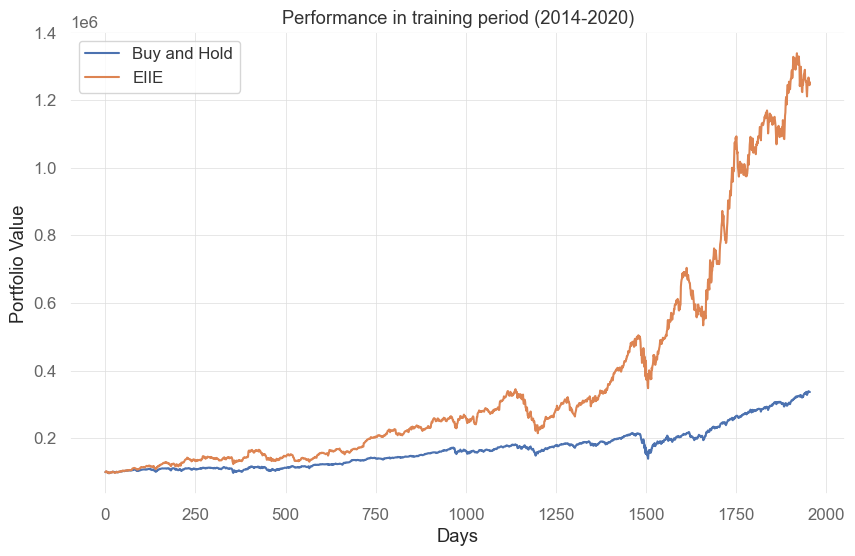

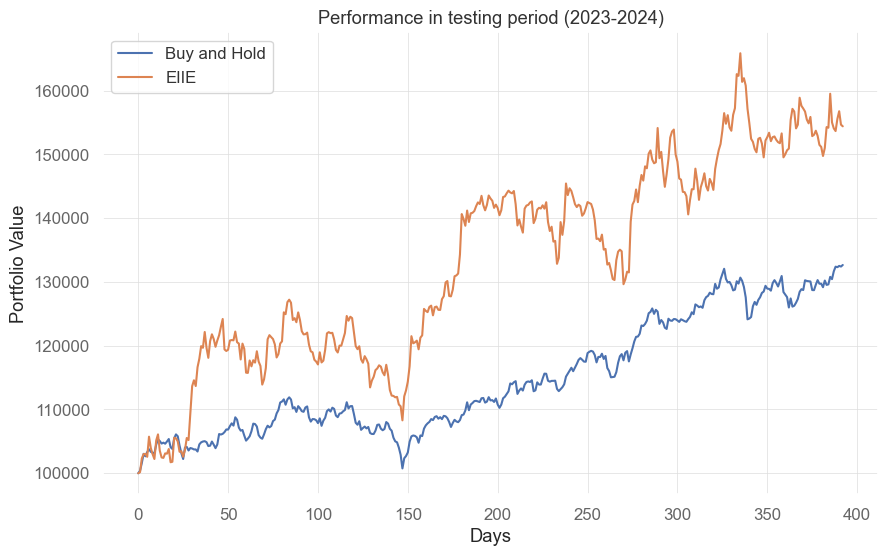

In [22]:
import os
import shutil

# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

train_env.reset()
src_folder = "hehe/rl"
dst_folder = "hehe/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, train_env, policy=EIIE_policy, learning_rate=0)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = train_env._asset_memory["final"]
EIIE_results["train"]["actions"] = train_env._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(train_env)

src_folder = "hehe/rl"
dst_folder = "hehe/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, test_env, policy=EIIE_policy, learning_rate =0)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = test_env._asset_memory["final"]
EIIE_results["test"]["actions"] = test_env._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(test_env)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]



#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []} }


PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
train_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = train_env.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = train_env._asset_memory["final"]

# test
terminated = False
test_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = test_env.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = test_env._asset_memory["final"]

metrics_df = pd.DataFrame(
                {
                    "date": test_env._date_memory,
                    "returns": test_env._portfolio_return_memory,
                    "rewards": test_env._portfolio_reward_memory,
                    "portfolio_values": test_env._asset_memory["final"],
                }
            )
metrics_df.to_csv("metrics_df.csv")

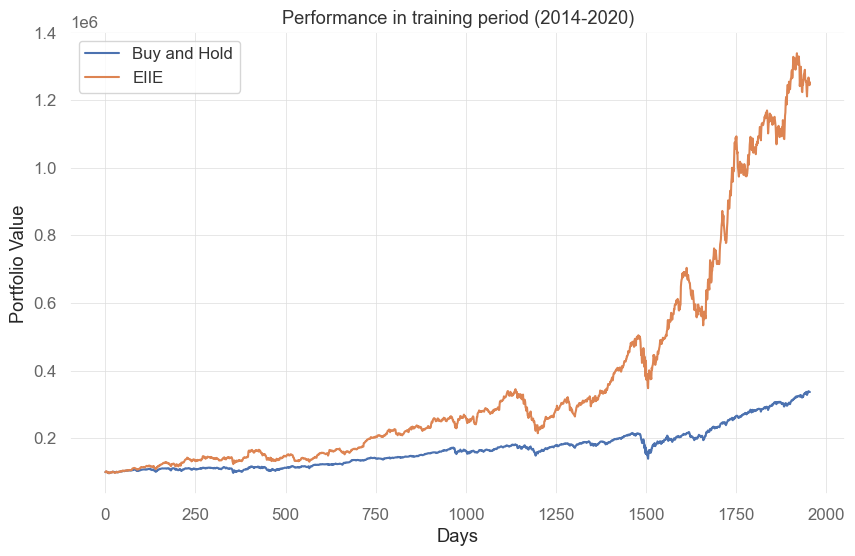

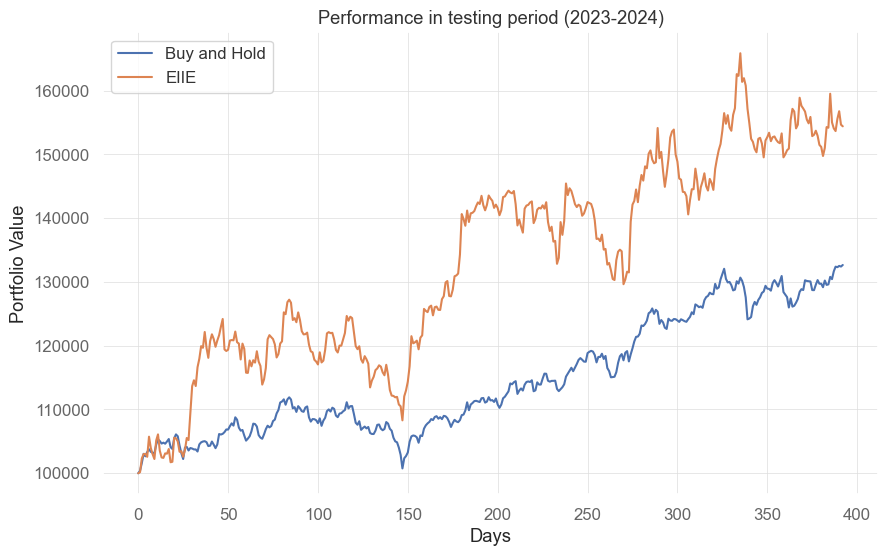

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()
plt.savefig("newresults/train_performance.jpg")
plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()
plt.savefig("newresults/test_performance.jpg")

plt.show()

In [24]:
# Create DataFrame for train UBAH results
UBAH_train_df = pd.DataFrame({
    "portfolio_value": UBAH_results["train"]["value"],
    "step": range(len(UBAH_results["train"]["value"])),
    "type": "train"
})

# Create DataFrame for test UBAH results
UBAH_test_df = pd.DataFrame({
    "portfolio_value": UBAH_results["test"]["value"],
    "step": range(len(UBAH_results["test"]["value"])),
    "type": "test"
})

# Combine the DataFrames
UBAH_results_df = pd.concat([UBAH_train_df, UBAH_test_df], ignore_index=True)

# Save to CSV
UBAH_results_df.to_csv("newresults/UBAH_baseline.csv", index=False)


C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\3196638666.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\3196638666.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_cum)


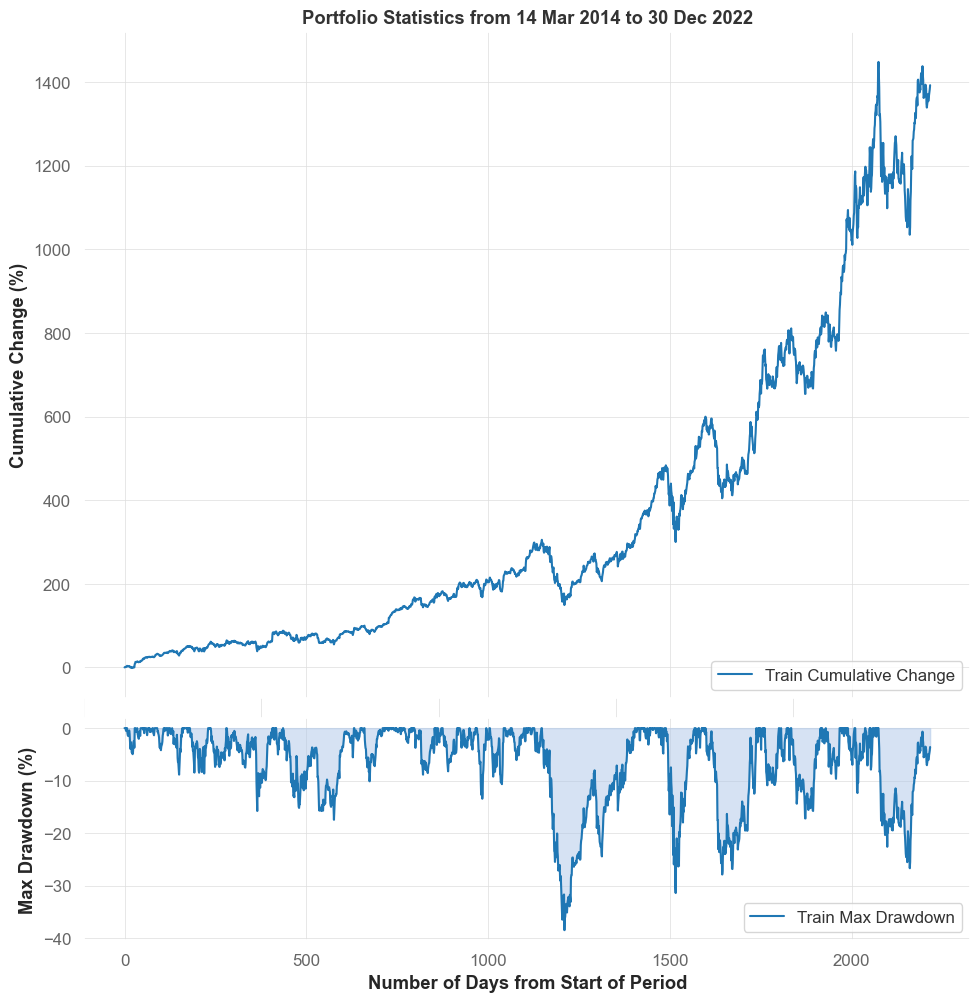

In [25]:

import matplotlib.pyplot as plt
import quantstats as qs
import matplotlib.gridspec as gridspec

metrics_rl = pd.read_csv("metrics_df_rl.csv")
metrics_train = pd.read_csv("metrics_data_train.csv")
metrics_test = pd.read_csv("metrics_data_test.csv")

def transform_df(df):
    df.reset_index(drop=False, inplace=True)  
    df.rename(columns={'index': 'row_number'}, inplace=True)

    def calculate_rowwise_max_drawdown(portfolio_values):
        portfolio_values = np.array(portfolio_values)
        max_drawdowns = np.zeros(len(portfolio_values))  # Array to hold max drawdowns for each time step
        running_max = -np.inf  # Initialize running max to negative infinity
        for i in range(len(portfolio_values)):
            # Update the running maximum
            running_max = max(running_max, portfolio_values[i])
            # Calculate drawdown for the current value
            drawdown = (portfolio_values[i] - running_max) / running_max
            # Store the maximum drawdown observed up to this point
            max_drawdowns[i] = drawdown if drawdown < 0 else 0  # Only store negative drawdowns
        return max_drawdowns

    df['max_drawdown'] = calculate_rowwise_max_drawdown(df['portfolio_values'])*100
    df['cumulative_change'] = ((df['portfolio_values'] - df['portfolio_values'][0])/df['portfolio_values'][0])*100
    return df

metrics_rl_plot = transform_df(metrics_rl)
metrics_train_plot = transform_df(metrics_train)
metrics_test_plot = transform_df(metrics_test)

def qs_plotter(df):
    train_color_cum =  "#1f77b4" 
    train_color_dd =   "#aec7e8"  
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime("%d %b %Y")
    earliest_date = df['date'][0]
    latest_date = df['date'][len(df)-1]
    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change (%)", fontweight='bold')
    ax1.legend(loc="lower right")  # Move legend to the right



    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_cum)
    ax2.fill_between(df['row_number'], df["max_drawdown"], 0, 
                    color= train_color_dd, alpha=0.5)
    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    # ax2.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3 = fig.add_subplot(gs[2])  # Smaller subplot
    # ax3.plot(df['row_number'], df["returns"]*100, "b")
    # ax3.set_ylabel("Daily Return (%)", fontweight='bold')
    # ax3.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 > 0), color='green', alpha=0.3)
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 < 0), color='red', alpha=0.3)
    ax2.legend(loc="lower right") # Adding legend for cumulative change
    plt.tight_layout()
    ax1.set_title(f"Portfolio Statistics from {earliest_date} to {latest_date}", fontweight='bold')
    plt.savefig("newresults/train_statistics.jpg")
    plt.close()
    return fig

plottrain = qs_plotter(metrics_train_plot)
plottrain



C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\3321136143.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df1['row_number'], df1["cumulative_change"], "b", label='RL Cumulative Change', color = rl_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\3321136143.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df2['row_number'], df2["cumulative_change"], "b", label='Test Cumulative Change', color = test_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\3321136143.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058

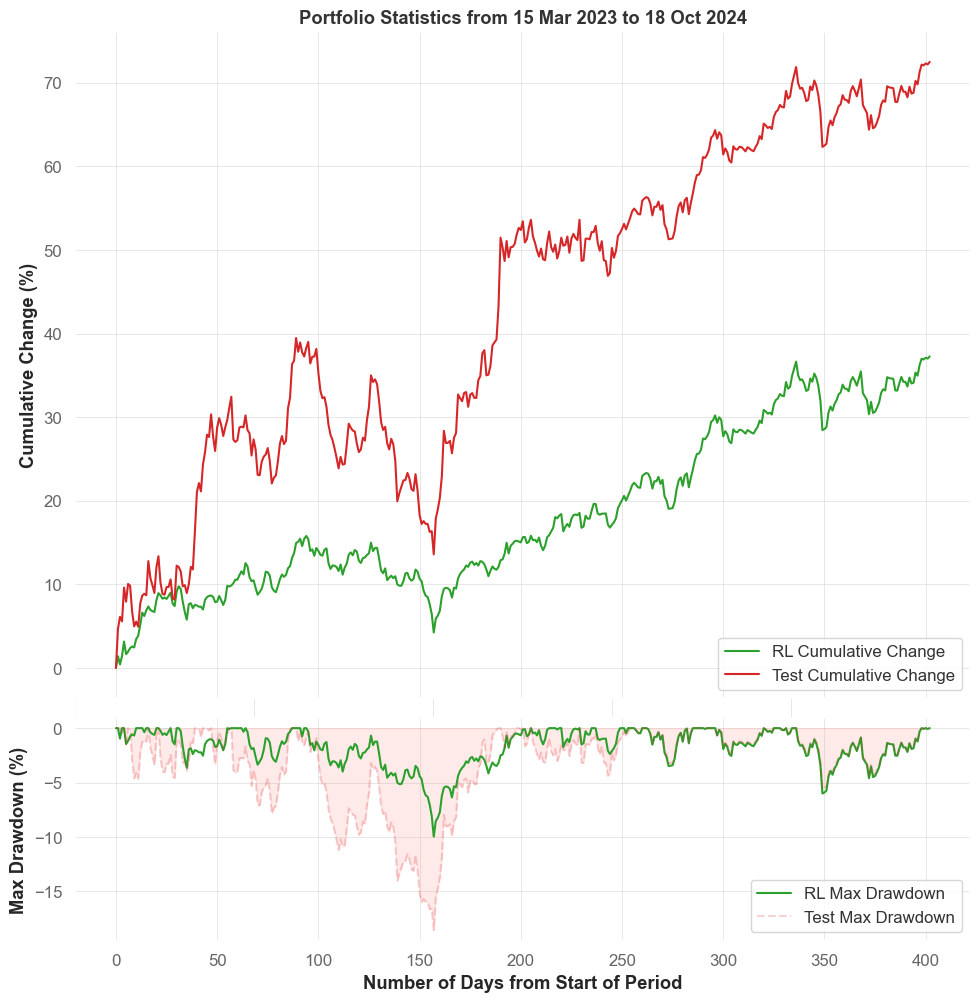

In [26]:
def qs_twoplots(df1, df2):


    rl_color_cum =   "#2ca02c"   
    train_color_cum =  "#1f77b4" 
    test_color_cum = "#d62728"

    rl_color_dd =   "#98df8a"
    train_color_dd =   "#aec7e8" 
    test_color_dd = "#ff9896"  


    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

    for df in [df1, df2]:
        df['date'] = pd.to_datetime(df['date'])
        df['date'] = df['date'].dt.strftime("%d %b %Y")



    earliest_date = min(df1['date'][0], df2['date'][0])
    latest_date = max(df1['date'][len(df1)-1], df2['date'][len(df2)-1])


    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df1['row_number'], df1["cumulative_change"], "b", label='RL Cumulative Change', color = rl_color_cum)
    ax1.plot(df2['row_number'], df2["cumulative_change"], "b", label='Test Cumulative Change', color = test_color_cum)

    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change (%)", fontweight='bold')
    ax1.legend(loc="lower right")  # Move legend to the right


    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df1['row_number'], df1["max_drawdown"], "r", label='RL Max Drawdown', color = rl_color_cum, linestyle='-')
    # ax2.fill_between(df1['row_number'], df1["max_drawdown"], 0, 
    #                 color=rl_color_dd, alpha=0.2)
    
    ax2.plot(df2['row_number'], df2["max_drawdown"], "r", label='Test Max Drawdown', color = test_color_cum, linestyle='--', alpha = 0.2)
    ax2.fill_between(df2['row_number'], df2["max_drawdown"], 0, 
                    color=test_color_dd, alpha=0.2)
    
    ax2.legend(loc="lower right") # Adding legend for cumulative change




    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    # ax2.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3 = fig.add_subplot(gs[2])  # Smaller subplot
    # ax3.plot(df['row_number'], df["returns"]*100, "b")
    # ax3.set_ylabel("Daily Return (%)", fontweight='bold')
    # ax3.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 > 0), color='green', alpha=0.3)
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 < 0), color='red', alpha=0.3)
    plt.tight_layout()
    ax1.set_title(f"Portfolio Statistics from {earliest_date} to {latest_date}", fontweight='bold')
    plt.savefig("newresults/vali_test_statistics.jpg")

    plt.close()
    return fig

plot1 = qs_twoplots(metrics_rl_plot, metrics_test_plot)
plot1


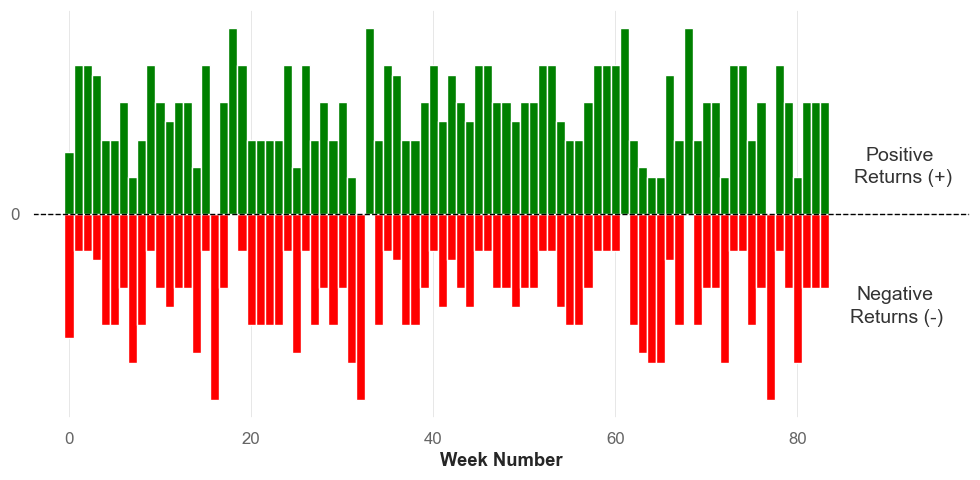

<Figure size 1000x600 with 0 Axes>

In [27]:
metrics_rl_plot['date'] = pd.to_datetime(metrics_rl_plot['date'])
metrics_rl_plot_monthly = (
    metrics_rl_plot.groupby(pd.Grouper(key='date', freq='W'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Negative Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Positive Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Week Number", fontweight='bold')
# ax.set_title("Win Rate of Portfolio by Week", fontweight='bold')
ax.set_yticks([0])  # Only show tick at 0
ax.set_yticklabels([0])  # Set the label for the tick

plt.annotate('Positive', (95, 25), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Negative', (95, -50), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (+)', (97, 13), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (-)', (96, -62), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
ax.set_xlim(left=-4, right=99)
# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()
plt.savefig("newresults/weekly_returns.jpg")



C:\Users\xutia\AppData\Local\Temp\ipykernel_30024\329937752.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  metrics_rl.groupby(pd.Grouper(key='date', freq='M'))


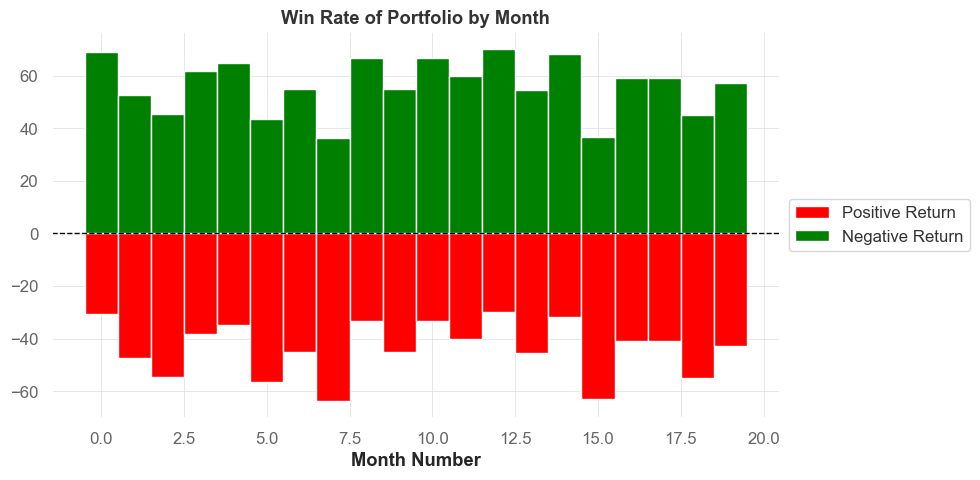

<Figure size 1000x600 with 0 Axes>

In [28]:
metrics_rl_plot_monthly = (
    metrics_rl.groupby(pd.Grouper(key='date', freq='M'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Positive Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Negative Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Month Number", fontweight='bold')
ax.set_title("Win Rate of Portfolio by Month", fontweight='bold')

# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()
plt.savefig("newresults/monthly_returns.jpg")


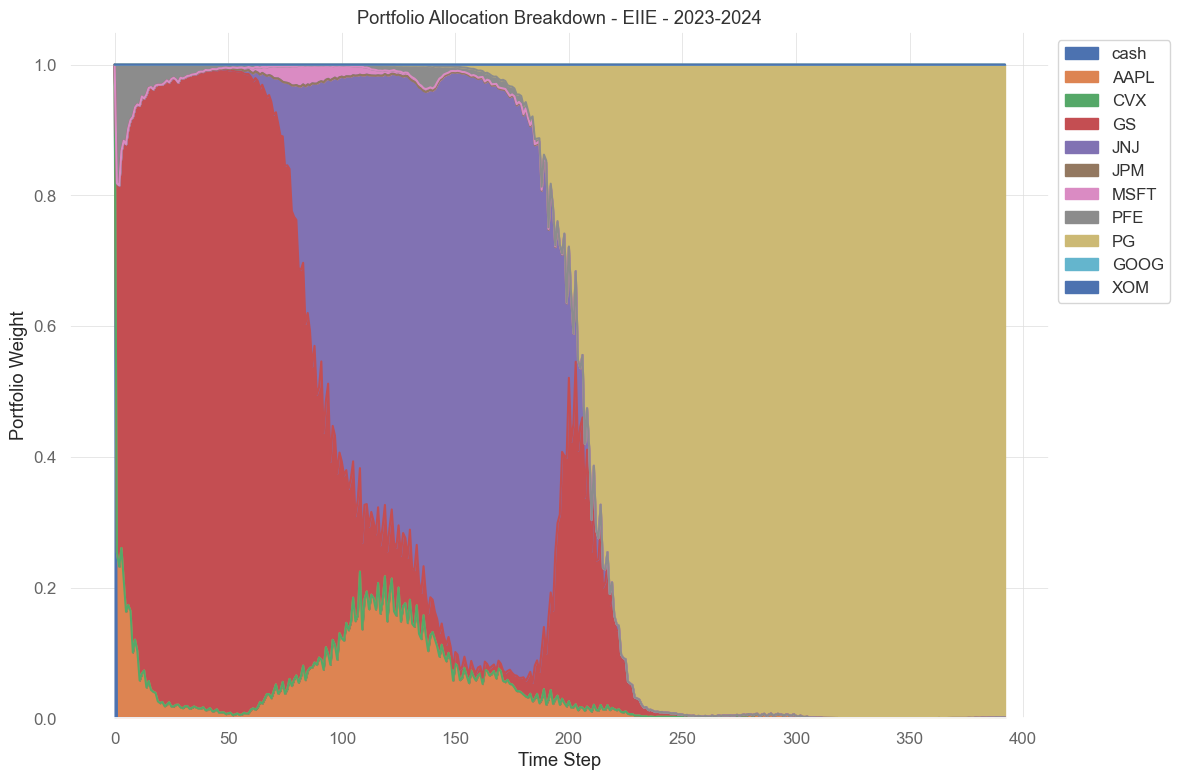

,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative
0,60,3,20,5,1252513.875,-0.377124,1.310665,12.525139,154416.390625,-0.148751,1.35875,1.544164
1,60,3,20,5,1252513.875,-0.377124,1.310665,12.525139,154416.390625,-0.148751,1.35875,1.544164
2,60,3,20,5,1252513.875,-0.377124,1.310665,12.525139,154416.390625,-0.148751,1.35875,1.544164


<Figure size 1000x600 with 0 Axes>

In [31]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="area", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("newresults/test_breakdown.jpg")


# Plot EIIE actions for the training period
# plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for test
plot_action_memory(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "test_portfolio_value": portfolio_test_value, "test_drawdown": drawdown_test, "test_sharpe": sharpe_test, "test_cumulative": cumulative_test}]
)
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

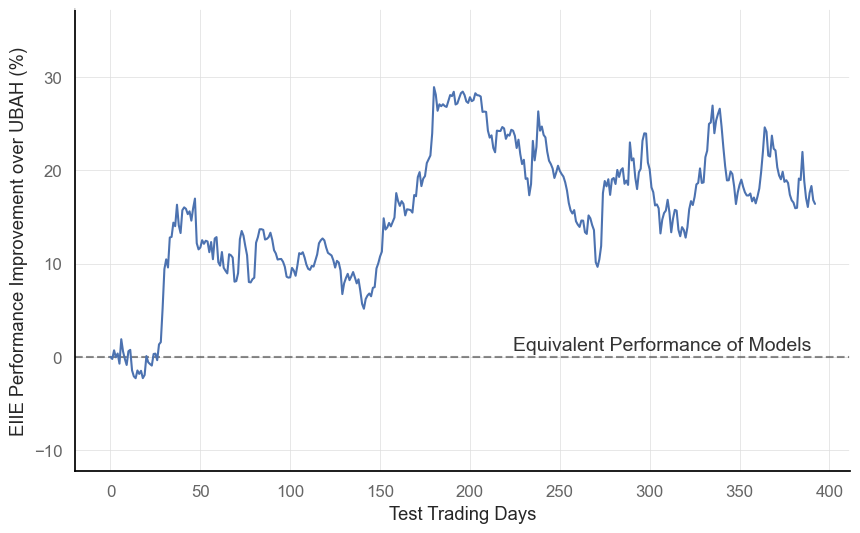

In [21]:
#diff =  EIIE_results["test"]["value"] - UBAH_results["test"]["value"]
normdiff = [(i -j)/j for i, j in zip(EIIE_results["test"]["value"], UBAH_results["test"]["value"])]
percentagediff = [i*100 for i in normdiff]
plt.axhspan(-10, 35, alpha=0)
#x axis line
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) 
plt.annotate('Equivalent Performance of Models', (390, -0.025), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
# plt.grid(False)

# Add solid lines for axes
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

#add labels
plt.xlabel("Test Trading Days")
plt.ylabel("EIIE Performance Improvement over UBAH (%)")
plt.plot(percentagediff)

